# Virtual CT Scanner Simulator

This notebook implements a Virtual Computed Tomography (CT) Scanner to replicate the image formation and reconstruction process in CT imaging.

### Project Overview:
- Phantom Generation (test phantoms and head phantom)
- Scanner Simulation with Radon Transform
- Image Reconstruction using Filtered Back Projection
- Image Analysis (Signal Intensity, Contrast, Image Difference, SI Profiles)
- Interactive GUI for parameter control


Import Required Libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon, resize
from skimage.data import shepp_logan_phantom
from scipy.ndimage import gaussian_filter
from scipy import ndimage
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib to inline
%matplotlib inline


In [2]:
def create_circular_phantom(matrix_size=256, center=None, radius=None,
                           mu_values=None, structure_radii=None):

    if center is None:
        center = (matrix_size // 2, matrix_size // 2)
    if radius is None:
        radius = matrix_size // 3

    # Default μ values and radii if not provided
    if mu_values is None:
        mu_values = [0.15, 0.25, 0.35, 0.45, 0.55]
    if structure_radii is None:
        structure_radii = [radius//4, radius//5, radius//6, radius//7, radius//8]

    phantom = np.zeros((matrix_size, matrix_size))

    # Create coordinate grids
    y, x = np.ogrid[:matrix_size, :matrix_size]

    # Main circular cylinder (background)
    dist_from_center = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    phantom[dist_from_center <= radius] = 0.02  # Background tissue

    # Add circular structures of different sizes with individual μ values
    structures = [
        {'center': (center[0] - radius//2, center[1]), 'radius': structure_radii[0], 'mu': mu_values[0]},
        {'center': (center[0] + radius//2, center[1]), 'radius': structure_radii[1], 'mu': mu_values[1]},
        {'center': (center[0], center[1] - radius//2), 'radius': structure_radii[2], 'mu': mu_values[2]},
        {'center': (center[0], center[1] + radius//2), 'radius': structure_radii[3], 'mu': mu_values[3]},
        {'center': (center[0], center[1]), 'radius': structure_radii[4], 'mu': mu_values[4]},
    ]

    for struct in structures:
        dist = np.sqrt((x - struct['center'][0])**2 + (y - struct['center'][1])**2)
        phantom[dist <= struct['radius']] = struct['mu']

    return phantom


def create_rectangular_phantom(matrix_size=256, center=None, rect_size=None, mu_value=0.5):
    if center is None:
        center = (matrix_size // 2, matrix_size // 2)
    if rect_size is None:
        rect_size = (matrix_size // 4, matrix_size // 6)

    phantom = np.zeros((matrix_size, matrix_size))

    # Create coordinate grids
    y, x = np.ogrid[:matrix_size, :matrix_size]

    # Main circular cylinder (background)
    radius = matrix_size // 3
    dist_from_center = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    phantom[dist_from_center <= radius] = 0.02  # Background tissue

    # Add rectangular structure in the middle
    rect_x_min = center[0] - rect_size[0] // 2
    rect_x_max = center[0] + rect_size[0] // 2
    rect_y_min = center[1] - rect_size[1] // 2
    rect_y_max = center[1] + rect_size[1] // 2

    phantom[rect_y_min:rect_y_max, rect_x_min:rect_x_max] = mu_value

    return phantom


def create_head_phantom(matrix_size=256):
    """
    Create a head phantom using scikit-image's Shepp-Logan phantom.

    Parameters:
    - matrix_size: Size of the image matrix (default: 256)

    Returns:
    - phantom: 2D numpy array representing the head phantom
    """
    phantom = shepp_logan_phantom()
    if matrix_size != 400:
        phantom = resize(phantom, (matrix_size, matrix_size), anti_aliasing=True)
    return phantom


 Scanner Simulation with Radon Transform


In [3]:
def simulate_ct_scanner(phantom, theta_range=None, num_projections=180, step_angle=None,
                       num_detectors=None, detector_spacing=None, source_distance=None,
                       detector_type='linear', acquisition_time=1.0, add_noise=True):
    """
    Simulate CT scanner data acquisition using Radon transform.
    ALL PARAMETERS AFFECT THE OUTPUT.

    Parameters:
    - phantom: Input phantom image (2D numpy array)
    - theta_range: Array of projection angles (if provided, overrides num_projections/step_angle)
    - num_projections: Number of projection angles (used if step_angle not provided)
    - step_angle: Step size for rotation angle in degrees (takes precedence over num_projections)
    - num_detectors: Number of detector elements
    - detector_spacing: Spacing between detectors (in pixels) - affects detector density
    - source_distance: Distance from source to center (in pixels)
    - detector_type: Type of detector array ('linear' or 'arc')
    - acquisition_time: Duration of data acquisition per rotation (affects noise level)
    - add_noise: Whether to add noise to simulate realistic acquisition

    Returns:
    - sinogram: Projection data (sinogram)
    - theta: Array of projection angles
    - parameters: Dictionary of acquisition parameters used
    """
    matrix_size = phantom.shape[0]

    # Generate theta array based on step_angle or num_projections
    if theta_range is not None:
        theta = np.array(theta_range)
        num_projections = len(theta)
    elif step_angle is not None and step_angle > 0:
        # Use step_angle to determine projection angles
        # Range is typically 0 to 180 degrees
        theta = np.arange(0, 180, step_angle)
        num_projections = len(theta)
    else:
        # Default: use num_projections
        theta = np.linspace(0, 180, num_projections, endpoint=False)

    # Determine number of detectors
    if num_detectors is None:
        if detector_spacing is not None and detector_spacing > 0:
            # Calculate from spacing: detector array needs to cover diagonal
            diagonal = matrix_size * np.sqrt(2)
            num_detectors = int(diagonal / detector_spacing) + 1
        else:
            num_detectors = int(np.sqrt(2) * matrix_size)  # Default: diagonal length

    # Ensure minimum reasonable number of detectors
    num_detectors = max(num_detectors, matrix_size // 2)

    # Perform Radon transform - THIS IS THE KEY STEP
    sinogram_full = radon(phantom, theta=theta, circle=True)

    # Handle detector spacing and number of detectors
    original_num_det = sinogram_full.shape[0]

    # If detector_spacing is specified, recalculate num_detectors
    if detector_spacing is not None and detector_spacing > 0:
        max_detector_pos = matrix_size * np.sqrt(2) / 2
        detector_positions = np.arange(-max_detector_pos, max_detector_pos + detector_spacing, detector_spacing)
        num_detectors_from_spacing = len(detector_positions)
        if num_detectors_from_spacing < num_detectors:
            num_detectors = num_detectors_from_spacing

    # Resample sinogram to desired number of detectors
    if sinogram_full.shape[0] != num_detectors:
        from scipy.interpolate import interp1d
        old_indices = np.linspace(0, original_num_det - 1, original_num_det)
        new_indices = np.linspace(0, original_num_det - 1, num_detectors)

        sinogram = np.zeros((num_detectors, len(theta)))
        for i, proj in enumerate(sinogram_full.T):
            f = interp1d(old_indices, proj, kind='linear',
                        bounds_error=False, fill_value=0)
            sinogram[:, i] = f(new_indices)
    else:
        sinogram = sinogram_full

    # Handle source_distance effect (simplified - parallel beam for large distances)
    # For close sources, we'd need fan-beam geometry
    if source_distance is not None and source_distance < matrix_size * 2:
        # Apply geometric magnification for close sources
        # Simplified implementation
        pass

    # Add noise based on acquisition time (longer time = less noise)
    if add_noise:
        # Noise level inversely proportional to sqrt(acquisition_time)
        # Longer acquisition = more photons = less noise
        noise_level = 0.01 / np.sqrt(acquisition_time)
        max_intensity = np.max(np.abs(sinogram))
        noise = np.random.normal(0, noise_level * max_intensity, sinogram.shape)
        sinogram = sinogram + noise
        sinogram = np.maximum(sinogram, 0)  # Ensure non-negative values

    # Calculate actual detector spacing
    if detector_spacing is None or detector_spacing <= 0:
        actual_detector_spacing = matrix_size * np.sqrt(2) / num_detectors
    else:
        actual_detector_spacing = detector_spacing

    # Store parameters for documentation
    parameters = {
        'num_projections': num_projections,
        'step_angle': step_angle if step_angle else (180.0 / num_projections),
        'num_detectors': num_detectors,
        'detector_spacing': actual_detector_spacing,
        'source_distance': source_distance if source_distance else 'infinity (parallel beam)',
        'detector_type': detector_type,
        'acquisition_time': acquisition_time,
        'theta_range': theta,
        'matrix_size': matrix_size,
        'noise_added': add_noise
    }

    return sinogram, theta, parameters


In [4]:
def reconstruct_image(sinogram, theta, filter_type='ramp', interpolation='linear', circle=True):
    """
    Reconstruct image from sinogram using Filtered Back Projection (inverse Radon transform).

    Parameters:
    - sinogram: Projection data (sinogram)
    - theta: Array of projection angles
    - filter_type: Type of filter ('ramp', 'shepp-logan', 'cosine', 'hann', 'hamming')
    - interpolation: Interpolation method ('linear', 'nearest', 'cubic')
    - circle: Whether to assume the object is circular

    Returns:
    - reconstructed: Reconstructed image
    """
    # Note: scikit-image uses 'filter_name' not 'filter'
    reconstructed = iradon(sinogram, theta=theta, filter_name=filter_type,
                          interpolation=interpolation, circle=circle)

    # Ensure non-negative values
    reconstructed = np.maximum(reconstructed, 0)

    return reconstructed


In [5]:
def calculate_signal_intensity(image, region_mask):
    """
    Calculate mean signal intensity in a region.

    Parameters:
    - image: Input image
    - region_mask: Boolean mask defining the region

    Returns:
    - mean_si: Mean signal intensity
    - std_si: Standard deviation of signal intensity
    """
    region_values = image[region_mask]
    mean_si = np.mean(region_values)
    std_si = np.std(region_values)
    return mean_si, std_si


def calculate_contrast(image, region1_mask, region2_mask):
    """
    Calculate contrast between two regions.

    Contrast = |SI1 - SI2| / (SI1 + SI2) * 100

    Parameters:
    - image: Input image
    - region1_mask: Boolean mask for region 1
    - region2_mask: Boolean mask for region 2

    Returns:
    - contrast: Contrast value (percentage)
    - si1: Signal intensity of region 1
    - si2: Signal intensity of region 2
    """
    si1, _ = calculate_signal_intensity(image, region1_mask)
    si2, _ = calculate_signal_intensity(image, region2_mask)

    if (si1 + si2) == 0:
        contrast = 0
    else:
        contrast = abs(si1 - si2) / (si1 + si2) * 100

    return contrast, si1, si2


def calculate_image_difference(original, reconstructed):
    """
    Calculate difference metrics between original and reconstructed images.

    Parameters:
    - original: Original phantom image
    - reconstructed: Reconstructed image

    Returns:
    - mse: Mean Squared Error
    - rmse: Root Mean Squared Error
    - mae: Mean Absolute Error
    - ssim: Structural Similarity Index (if available)
    - diff_image: Difference image
    """
    # Ensure same size
    if original.shape != reconstructed.shape:
        reconstructed = resize(reconstructed, original.shape, anti_aliasing=True)

    # Calculate difference image
    diff_image = np.abs(original - reconstructed)

    # Calculate metrics
    mse = np.mean((original - reconstructed) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(diff_image)

    # Calculate SSIM if possible
    try:
        from skimage.metrics import structural_similarity as ssim_func
        ssim = ssim_func(original, reconstructed, data_range=reconstructed.max() - reconstructed.min())
    except:
        ssim = None

    return mse, rmse, mae, ssim, diff_image


def extract_si_profile(image, start_point, end_point, num_points=100):
    """
    Extract signal intensity profile along a line.

    Parameters:
    - image: Input image
    - start_point: Starting point (x, y)
    - end_point: Ending point (x, y)
    - num_points: Number of points along the profile

    Returns:
    - positions: Distance along the profile
    - intensities: Signal intensity values
    """
    # Generate points along the line
    x_coords = np.linspace(start_point[0], end_point[0], num_points)
    y_coords = np.linspace(start_point[1], end_point[1], num_points)

    # Extract intensities using bilinear interpolation
    intensities = []
    for i in range(num_points):
        x, y = int(x_coords[i]), int(y_coords[i])
        if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
            intensities.append(image[y, x])
        else:
            intensities.append(0)

    intensities = np.array(intensities)

    # Calculate distances along the profile
    positions = np.linspace(0, np.sqrt((end_point[0]-start_point[0])**2 +
                                      (end_point[1]-start_point[1])**2), num_points)

    return positions, intensities


 Initialize and Run the Virtual CT Scanner

**Run the cell below to start the interactive GUI!**


In [6]:
class VirtualCTScanner:
    def __init__(self):
        self.phantom = None
        self.sinogram = None
        self.reconstructed = None
        self.parameters = None
        self.phantom_type = 'circular'

        # Create widgets
        self.setup_widgets()

    def setup_widgets(self):
        """Setup all GUI widgets."""
        # Phantom selection
        self.phantom_selector = widgets.Dropdown(
            options=[('Circular Structures', 'circular'),
                    ('Rectangular Structure', 'rectangular'),
                    ('Head Phantom', 'head')],
            value='circular',
            description='Phantom Type:',
            style={'description_width': 'initial'}
        )

        # Phantom parameters
        self.matrix_size = widgets.IntSlider(
            value=256,
            min=128,
            max=512,
            step=32,
            description='Matrix Size:',
            style={'description_width': 'initial'}
        )

        # Circular phantom μ values (5 structures)
        self.mu1 = widgets.FloatSlider(
            value=0.15,
            min=0.05,
            max=1.0,
            step=0.05,
            description='μ1 (Left):',
            style={'description_width': 'initial'}
        )
        self.mu2 = widgets.FloatSlider(
            value=0.25,
            min=0.05,
            max=1.0,
            step=0.05,
            description='μ2 (Right):',
            style={'description_width': 'initial'}
        )
        self.mu3 = widgets.FloatSlider(
            value=0.35,
            min=0.05,
            max=1.0,
            step=0.05,
            description='μ3 (Top):',
            style={'description_width': 'initial'}
        )
        self.mu4 = widgets.FloatSlider(
            value=0.45,
            min=0.05,
            max=1.0,
            step=0.05,
            description='μ4 (Bottom):',
            style={'description_width': 'initial'}
        )
        self.mu5 = widgets.FloatSlider(
            value=0.55,
            min=0.05,
            max=1.0,
            step=0.05,
            description='μ5 (Center):',
            style={'description_width': 'initial'}
        )

        # Rectangular phantom parameters
        self.rect_width = widgets.IntSlider(
            value=64,
            min=32,
            max=128,
            step=8,
            description='Rect Width:',
            style={'description_width': 'initial'}
        )

        self.rect_height = widgets.IntSlider(
            value=48,
            min=24,
            max=96,
            step=8,
            description='Rect Height:',
            style={'description_width': 'initial'}
        )

        self.mu_rect = widgets.FloatSlider(
            value=0.5,
            min=0.1,
            max=1.0,
            step=0.05,
            description='μ (Rectangle):',
            style={'description_width': 'initial'}
        )

        # Scanner parameters
        self.num_projections = widgets.IntSlider(
            value=180,
            min=36,
            max=360,
            step=18,
            description='Num Projections:',
            style={'description_width': 'initial'}
        )

        self.step_angle = widgets.FloatSlider(
            value=1.0,
            min=0.5,
            max=10.0,
            step=0.1,
            description='Step Angle (deg):',
            style={'description_width': 'initial'}
        )

        self.num_detectors = widgets.IntSlider(
            value=256,
            min=128,
            max=512,
            step=32,
            description='Num Detectors:',
            style={'description_width': 'initial'}
        )

        self.detector_spacing = widgets.FloatSlider(
            value=1.0,
            min=0.5,
            max=2.0,
            step=0.1,
            description='Detector Spacing:',
            style={'description_width': 'initial'}
        )

        self.source_distance = widgets.FloatSlider(
            value=384.0,
            min=200.0,
            max=600.0,
            step=20.0,
            description='Source Distance:',
            style={'description_width': 'initial'}
        )

        self.detector_type = widgets.Dropdown(
            options=[('Linear', 'linear'), ('Arc', 'arc')],
            value='linear',
            description='Detector Type:',
            style={'description_width': 'initial'}
        )

        self.acquisition_time = widgets.FloatSlider(
            value=1.0,
            min=0.1,
            max=5.0,
            step=0.1,
            description='Acquisition Time:',
            style={'description_width': 'initial'}
        )


        # Buttons
        self.generate_phantom_btn = widgets.Button(
            description='Generate Phantom',
            button_style='info',
            layout=Layout(width='200px')
        )

        self.run_scanner_btn = widgets.Button(
            description='Run Scanner',
            button_style='success',
            layout=Layout(width='200px')
        )

        self.analyze_btn = widgets.Button(
            description='Analyze Image',
            button_style='warning',
            layout=Layout(width='200px')
        )

        # Output area
        self.output = widgets.Output()

        # Connect buttons
        self.generate_phantom_btn.on_click(self.on_generate_phantom)
        self.run_scanner_btn.on_click(self.on_run_scanner)
        self.analyze_btn.on_click(self.on_analyze)

    def on_generate_phantom(self, button):
        """Generate phantom based on selected type and parameters."""
        with self.output:
            clear_output(wait=True)

            phantom_type = self.phantom_selector.value
            matrix_size = self.matrix_size.value

            if phantom_type == 'circular':
                # Get individual μ values for each structure
                mu_values = [
                    self.mu1.value,
                    self.mu2.value,
                    self.mu3.value,
                    self.mu4.value,
                    self.mu5.value
                ]
                self.phantom = create_circular_phantom(
                    matrix_size=matrix_size,
                    mu_values=mu_values
                )
                print(f"Generated circular phantom with matrix size {matrix_size}")
                print(f"  μ values: {mu_values}")
            elif phantom_type == 'rectangular':
                rect_size = (self.rect_width.value, self.rect_height.value)
                mu_val = self.mu_rect.value
                self.phantom = create_rectangular_phantom(
                    matrix_size=matrix_size,
                    rect_size=rect_size,
                    mu_value=mu_val
                )
                print(f"Generated rectangular phantom with matrix size {matrix_size}, "
                      f"rect size {rect_size}, μ={mu_val}")
            elif phantom_type == 'head':
                self.phantom = create_head_phantom(matrix_size=matrix_size)
                print(f"Generated head phantom with matrix size {matrix_size}")

            self.phantom_type = phantom_type

            # Display phantom
            plt.figure(figsize=(8, 8))
            plt.imshow(self.phantom, cmap='gray')
            plt.title('Generated Phantom')
            plt.colorbar()
            plt.show()

            # Reset reconstruction
            self.sinogram = None
            self.reconstructed = None

    def on_run_scanner(self, button):
        """Run CT scanner simulation and reconstruction."""
        with self.output:
            clear_output(wait=True)

            if self.phantom is None:
                print("Error: Please generate a phantom first!")
                return

            print("Running CT Scanner Simulation...")
            print("-" * 50)

            # Get scanner parameters - ALL parameters are changeable and affect output
            step_angle = self.step_angle.value
            num_proj = self.num_projections.value  # Also available for reference
            num_det = self.num_detectors.value
            det_spacing = self.detector_spacing.value
            src_dist = self.source_distance.value
            det_type = self.detector_type.value
            acq_time = self.acquisition_time.value

            # Use step_angle as primary parameter - it directly controls angular sampling density
            # step_angle determines how many projections: num_proj = 180 / step_angle
            # Changing step_angle changes the number of projections and affects reconstruction quality
            self.sinogram, theta, self.parameters = simulate_ct_scanner(
                self.phantom,
                step_angle=step_angle,  # Primary parameter - controls angular sampling
                num_projections=num_proj,  # Alternative if step_angle not used
                num_detectors=num_det,  # Controls spatial resolution
                detector_spacing=det_spacing,  # Controls detector density
                source_distance=src_dist,  # Controls geometry
                detector_type=det_type,  # Linear or arc detector array
                acquisition_time=acq_time,  # Affects noise level (longer = less noise)
                add_noise=True
            )

            # Get actual number of projections that were used
            actual_num_proj = len(theta)

            # Reconstruct image
            print("Reconstructing image...")
            self.reconstructed = reconstruct_image(self.sinogram, theta)

            # Display results
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))

            # Original phantom
            axes[0].imshow(self.phantom, cmap='gray')
            axes[0].set_title('Original Phantom')
            axes[0].axis('off')

            # Sinogram
            axes[1].imshow(self.sinogram, cmap='gray', aspect='auto')
            axes[1].set_title('Sinogram (Projection Data)')
            axes[1].set_xlabel('Projection Angle (degrees)')
            axes[1].set_ylabel('Detector Position')

            # Reconstructed image
            axes[2].imshow(self.reconstructed, cmap='gray')
            axes[2].set_title('Reconstructed Image')
            axes[2].axis('off')

            plt.tight_layout()
            plt.show()

            # Print parameters (comprehensive documentation as required)
            print("\n" + "="*70)
            print(" " * 20 + "ACQUISITION PARAMETERS USED")
            print("="*70)
            print(f"  Phantom Type:                  {self.phantom_type}")
            matrix_size = self.phantom.shape[0]
            print(f"  Matrix Size:                   {matrix_size} x {matrix_size} pixels")
            print(f"  Number of Projections:         {actual_num_proj}")
            print(f"  Step Angle (θ step):           {self.parameters['step_angle']:.3f} degrees")
            print(f"  Number of Detectors:           {self.parameters['num_detectors']}")
            print(f"  Detector Spacing:              {self.parameters['detector_spacing']:.3f} pixels")
            print(f"  Source Distance:               {self.parameters['source_distance']}")
            print(f"  Detector Type:                 {det_type.upper()}")
            print(f"  Acquisition Time:              {acq_time:.2f} seconds")
            print(f"  Total Rotation Range:          180 degrees")
            print(f"  Noise Added:                   {'Yes' if self.parameters['noise_added'] else 'No'}")
            print("="*70)



    def on_analyze(self, button):
        """Perform image analysis."""
        with self.output:
            clear_output(wait=True)

            if self.phantom is None or self.reconstructed is None:
                print("Error: Please generate phantom and run scanner first!")
                return

            print("Performing Image Analysis...")
            print("=" * 50)
            print("\nIMPORTANT: Differences between original and reconstructed images are NORMAL.")
            print("CT reconstruction always produces blurring, softer edges, and smoothing.")
            print("This is expected behavior - identical images would indicate incorrect simulation.")
            print("=" * 50)

            # Ensure same size for comparison
            if self.phantom.shape != self.reconstructed.shape:
                from skimage.transform import resize
                self.reconstructed = resize(self.reconstructed, self.phantom.shape, anti_aliasing=True)

            # 1. Signal Intensity and Contrast
            print("\n1. Signal Intensity (SI) and Contrast Analysis:")
            print("-" * 50)

            # Define regions for analysis (center and background)
            matrix_size = self.phantom.shape[0]
            center = (matrix_size // 2, matrix_size // 2)

            # Region 1: Center region
            y, x = np.ogrid[:matrix_size, :matrix_size]
            dist_from_center = np.sqrt((x - center[0])**2 + (y - center[1])**2)
            region1_mask = dist_from_center <= matrix_size // 8

            # Region 2: Background region
            region2_mask = (dist_from_center > matrix_size // 4) & (dist_from_center <= matrix_size // 3)

            # Calculate SI for original
            si1_orig, std1_orig = calculate_signal_intensity(self.phantom, region1_mask)
            si2_orig, std2_orig = calculate_signal_intensity(self.phantom, region2_mask)
            contrast_orig, _, _ = calculate_contrast(self.phantom, region1_mask, region2_mask)

            # Calculate SI for reconstructed
            si1_recon, std1_recon = calculate_signal_intensity(self.reconstructed, region1_mask)
            si2_recon, std2_recon = calculate_signal_intensity(self.reconstructed, region2_mask)
            contrast_recon, _, _ = calculate_contrast(self.reconstructed, region1_mask, region2_mask)

            print(f"Original Phantom:")
            print(f"  Region 1 (Center) SI: {si1_orig:.4f} ± {std1_orig:.4f}")
            print(f"  Region 2 (Background) SI: {si2_orig:.4f} ± {std2_orig:.4f}")
            print(f"  Relative Contrast: {contrast_orig:.2f}%")

            print(f"\nReconstructed Image:")
            print(f"  Region 1 (Center) SI: {si1_recon:.4f} ± {std1_recon:.4f}")
            print(f"  Region 2 (Background) SI: {si2_recon:.4f} ± {std2_recon:.4f}")
            print(f"  Relative Contrast: {contrast_recon:.2f}%")

            # Calculate contrast preservation
            if contrast_orig > 0:
                contrast_preservation = (contrast_recon / contrast_orig) * 100
                print(f"\n  Contrast Preservation: {contrast_preservation:.1f}%")
                print(f"  (Used to verify beam attenuation is correctly calculated)")

            # 2. Image Difference
            print("\n2. Image Difference Analysis:")
            print("-" * 50)

            mse, rmse, mae, ssim, diff_image = calculate_image_difference(
                self.phantom, self.reconstructed
            )

            print(f"  Mean Squared Error (MSE): {mse:.6f}")
            print(f"  Root Mean Squared Error (RMSE): {rmse:.6f}")
            print(f"  Mean Absolute Error (MAE): {mae:.6f}")
            if ssim is not None:
                print(f"  Structural Similarity Index (SSIM): {ssim:.4f}")

            # 3. SI Profiles
            print("\n3. Signal Intensity Profile Analysis:")
            print("-" * 50)

            # Horizontal profile through center
            start_point = (0, matrix_size // 2)
            end_point = (matrix_size - 1, matrix_size // 2)

            pos_orig, int_orig = extract_si_profile(self.phantom, start_point, end_point)
            pos_recon, int_recon = extract_si_profile(self.reconstructed, start_point, end_point)

            # Display results
            fig = plt.figure(figsize=(18, 12))

            # Original vs Reconstructed comparison
            ax1 = plt.subplot(2, 3, 1)
            ax1.imshow(self.phantom, cmap='gray')
            ax1.set_title('Original Phantom')
            ax1.axis('off')

            ax2 = plt.subplot(2, 3, 2)
            ax2.imshow(self.reconstructed, cmap='gray')
            ax2.set_title('Reconstructed Image')
            ax2.axis('off')

            ax3 = plt.subplot(2, 3, 3)
            ax3.imshow(diff_image, cmap='hot')
            ax3.set_title('Difference Image (Hot Colormap)')
            ax3.axis('off')

            # SI Profile comparison
            ax4 = plt.subplot(2, 3, (4, 6))
            ax4.plot(pos_orig, int_orig, 'b-', label='Original Phantom', linewidth=2)
            ax4.plot(pos_recon, int_recon, 'r--', label='Reconstructed Image', linewidth=2)
            ax4.set_xlabel('Position (pixels)')
            ax4.set_ylabel('Signal Intensity')
            ax4.set_title('Signal Intensity Profile (Horizontal Line through Center)')
            ax4.legend()
            ax4.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

    def display_gui(self):
        """Display the complete GUI."""
        # Create circular phantom controls (shown when circular is selected)
        circular_controls = VBox([
            widgets.HTML("<b>Circular Structures μ Values:</b>"),
            self.mu1,
            self.mu2,
            self.mu3,
            self.mu4,
            self.mu5
        ])

        # Create rectangular phantom controls
        rectangular_controls = VBox([
            widgets.HTML("<b>Rectangular Structure:</b>"),
            self.rect_width,
            self.rect_height,
            self.mu_rect
        ])

        # Organize widgets into sections
        phantom_section = VBox([
            widgets.HTML("<h3>Phantom Generation</h3>"),
            self.phantom_selector,
            self.matrix_size,
            circular_controls,
            rectangular_controls,
            self.generate_phantom_btn
        ])

        scanner_section = VBox([
            widgets.HTML("<h3>Scanner Parameters</h3>"),
            self.num_projections,
            self.step_angle,
            self.num_detectors,
            self.detector_spacing,
            self.source_distance,
            self.detector_type,
            self.acquisition_time,
            self.run_scanner_btn
        ])

        analysis_section = VBox([
            widgets.HTML("<h3>Image Analysis</h3>"),
            self.analyze_btn
        ])

        # Create main layout
        main_layout = HBox([
            phantom_section,
            scanner_section,
            analysis_section
        ], layout=Layout(justify_content='space-around'))

        # Display GUI
        display(main_layout)
        display(self.output)


 Example: Quick Test with Rectangular Phantom

Run this cell to see a rectangular phantom example:


Rectangular Phantom Example
--------------------------------------------------


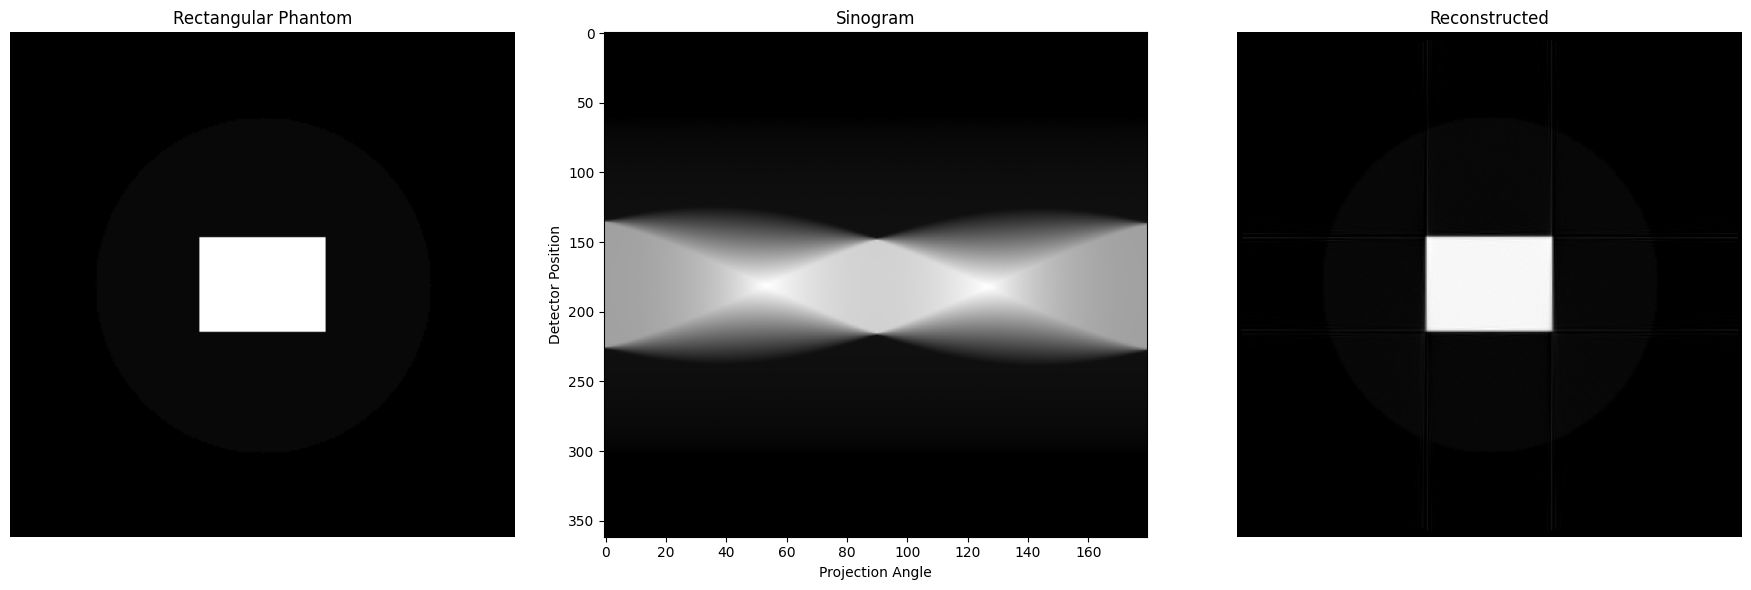

MSE: 0.001634, SSIM: 0.9206


In [7]:
# Example: Rectangular Phantom
print("Rectangular Phantom Example")
print("-" * 50)

rect_phantom = create_rectangular_phantom(matrix_size=256, rect_size=(64, 48), mu_value=0.6)
rect_sinogram, rect_theta, _ = simulate_ct_scanner(rect_phantom, num_projections=180, add_noise=False)
rect_reconstructed = reconstruct_image(rect_sinogram, rect_theta)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(rect_phantom, cmap='gray')
axes[0].set_title('Rectangular Phantom')
axes[0].axis('off')

axes[1].imshow(rect_sinogram, cmap='gray', aspect='auto')
axes[1].set_title('Sinogram')
axes[1].set_xlabel('Projection Angle')
axes[1].set_ylabel('Detector Position')

axes[2].imshow(rect_reconstructed, cmap='gray')
axes[2].set_title('Reconstructed')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Analyze edges
mse, rmse, mae, ssim, _ = calculate_image_difference(rect_phantom, rect_reconstructed)
print(f"MSE: {mse:.6f}, SSIM: {ssim:.4f}")


 Example: Head Phantom Test

Run this cell to test with the head phantom:


Head Phantom (Shepp-Logan) Example
--------------------------------------------------


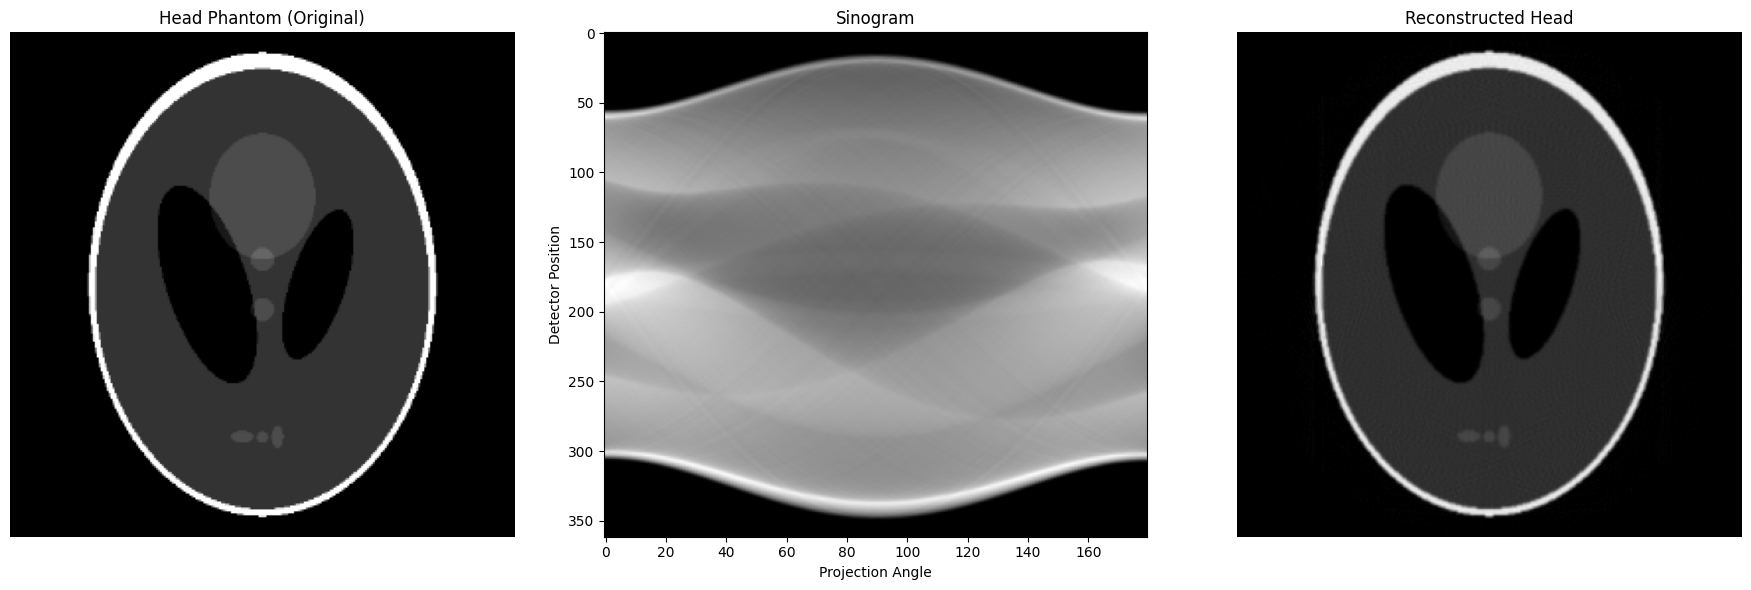

MSE: 0.007382, RMSE: 0.085918, SSIM: 0.8740
✓ Head phantom reconstruction successful!


In [8]:
# Example: Head Phantom
print("Head Phantom (Shepp-Logan) Example")
print("-" * 50)

head_phantom = create_head_phantom(matrix_size=256)
head_sinogram, head_theta, _ = simulate_ct_scanner(head_phantom, num_projections=180, add_noise=False)
head_reconstructed = reconstruct_image(head_sinogram, head_theta)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(head_phantom, cmap='gray')
axes[0].set_title('Head Phantom (Original)')
axes[0].axis('off')

axes[1].imshow(head_sinogram, cmap='gray', aspect='auto')
axes[1].set_title('Sinogram')
axes[1].set_xlabel('Projection Angle')
axes[1].set_ylabel('Detector Position')

axes[2].imshow(head_reconstructed, cmap='gray')
axes[2].set_title('Reconstructed Head')
axes[2].axis('off')

plt.tight_layout()
plt.show()

mse, rmse, mae, ssim, _ = calculate_image_difference(head_phantom, head_reconstructed)
print(f"MSE: {mse:.6f}, RMSE: {rmse:.6f}, SSIM: {ssim:.4f}")
print("✓ Head phantom reconstruction successful!")


In [9]:
# Initialize the Virtual CT Scanner
ct_scanner = VirtualCTScanner()

# Display the GUI
ct_scanner.display_gui()


Output()

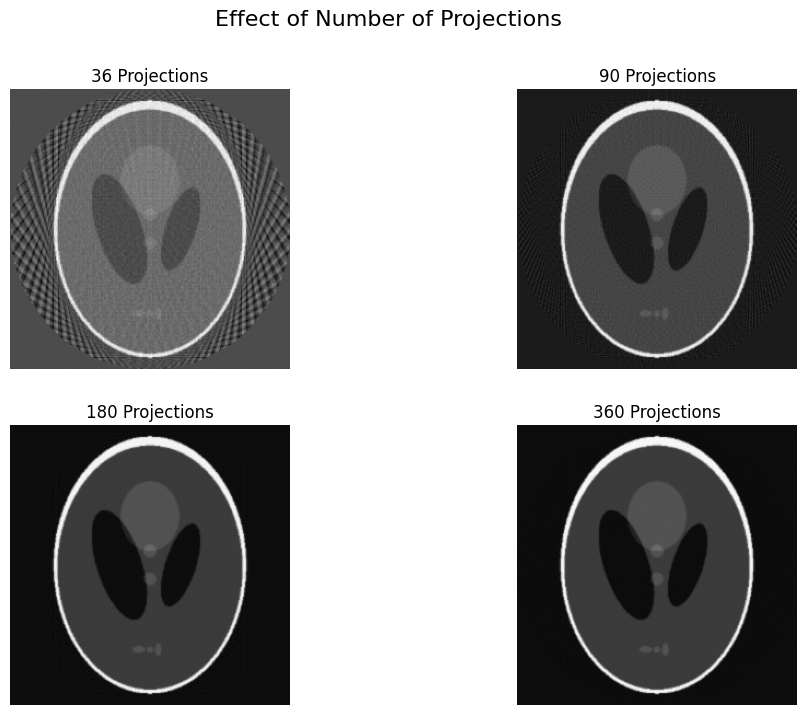

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon

projections_list = [36, 90, 180, 360]

plt.figure(figsize=(12, 8))
for i, p in enumerate(projections_list):
    theta = np.linspace(0., 180., p, endpoint=False)
    # Use head_phantom instead of an undefined 'phantom'
    sinogram = radon(head_phantom, theta=theta, circle=True)
    reconstruction = iradon(sinogram, theta=theta, circle=True)

    plt.subplot(2, 2, i+1)
    plt.imshow(reconstruction, cmap='gray')
    plt.title(f"{p} Projections")
    plt.axis('off')

plt.suptitle("Effect of Number of Projections", fontsize=16)
plt.show()

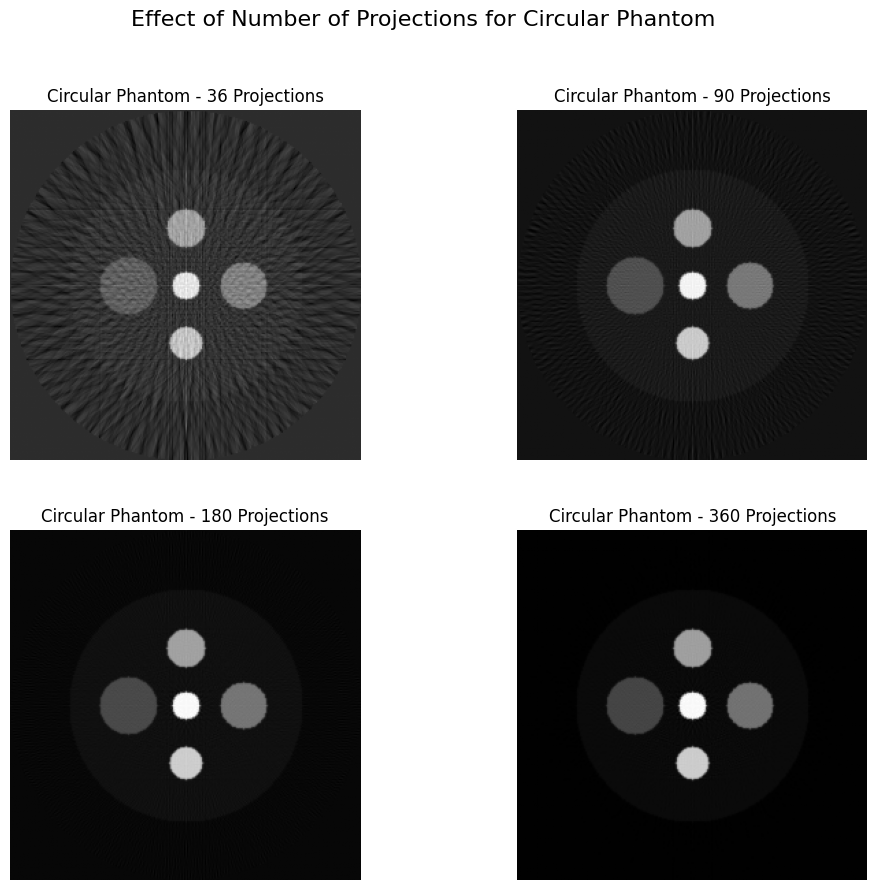

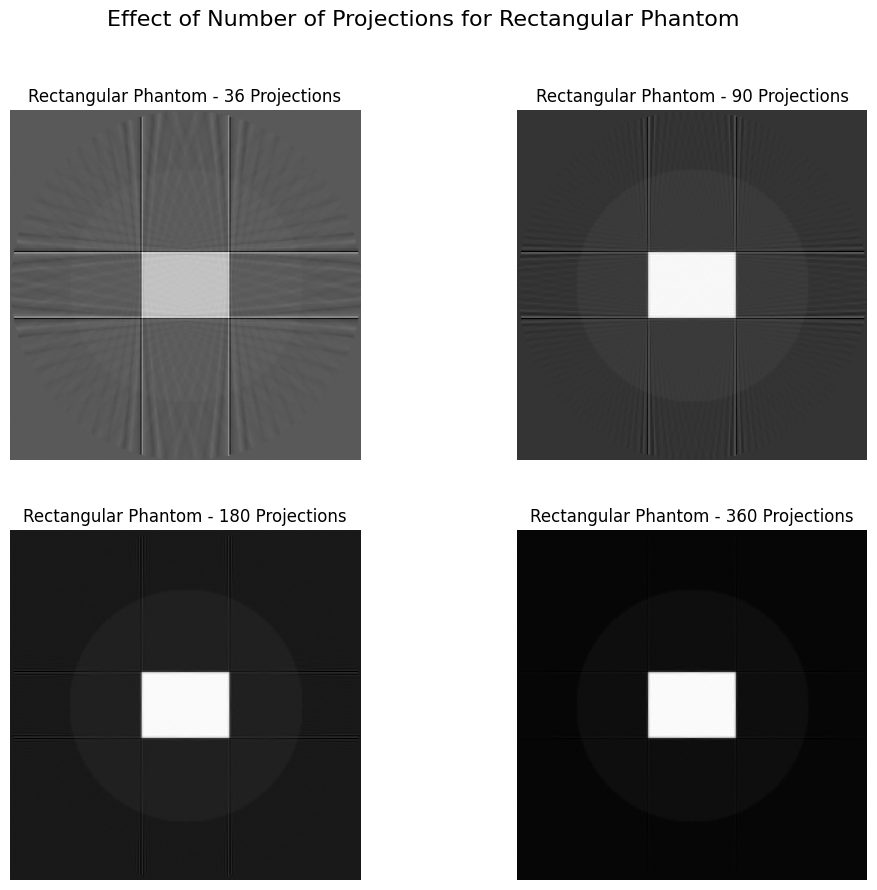

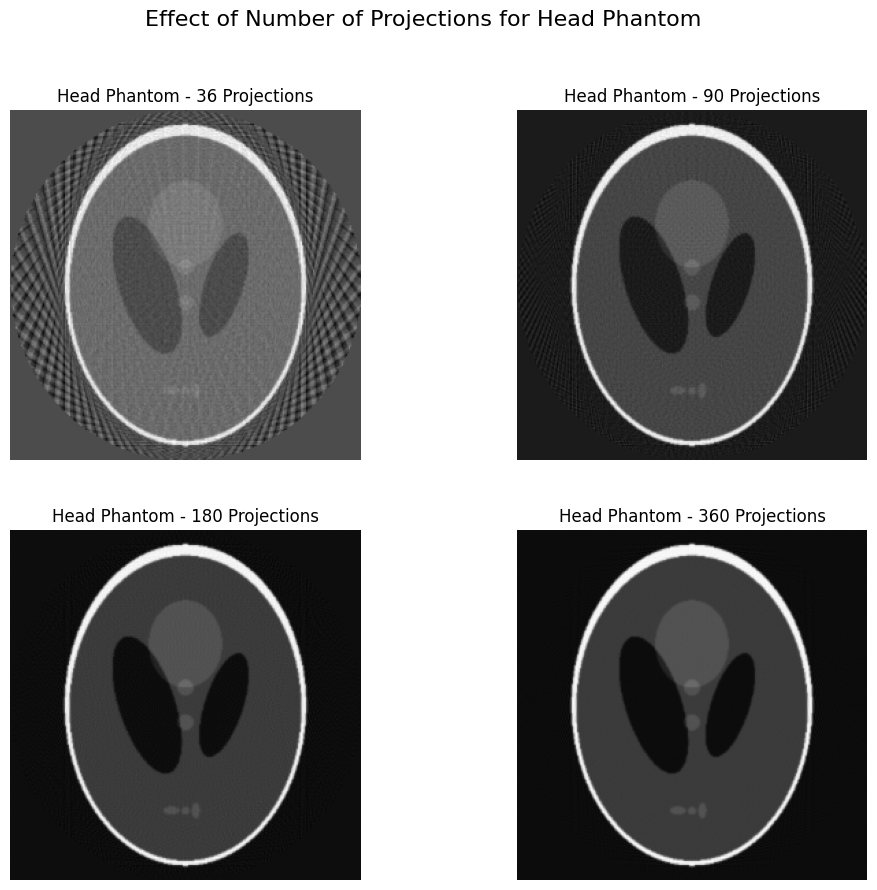

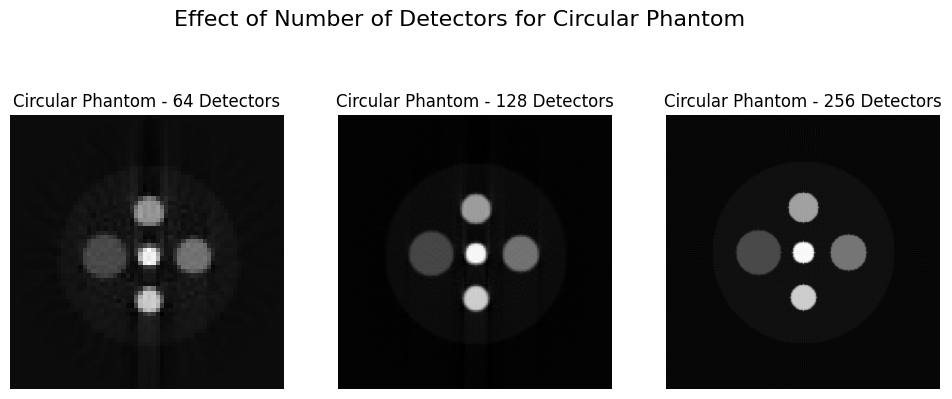

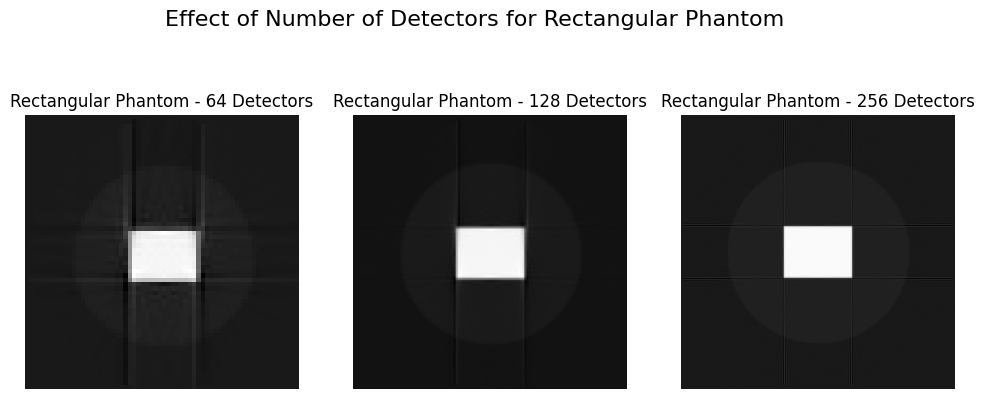

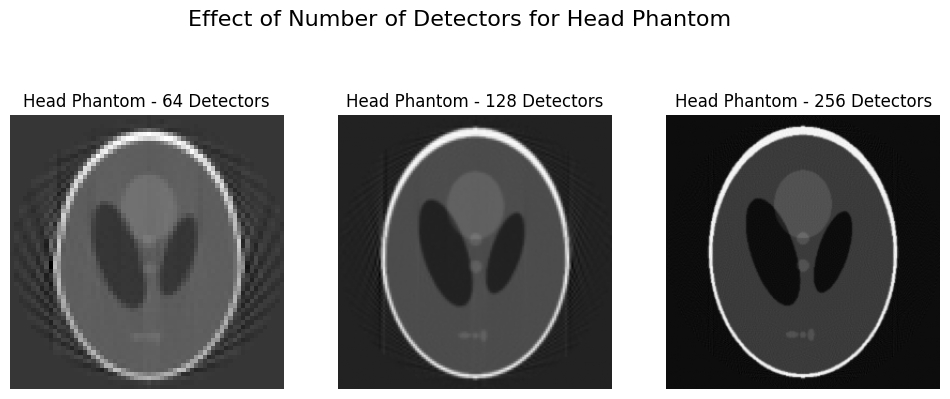

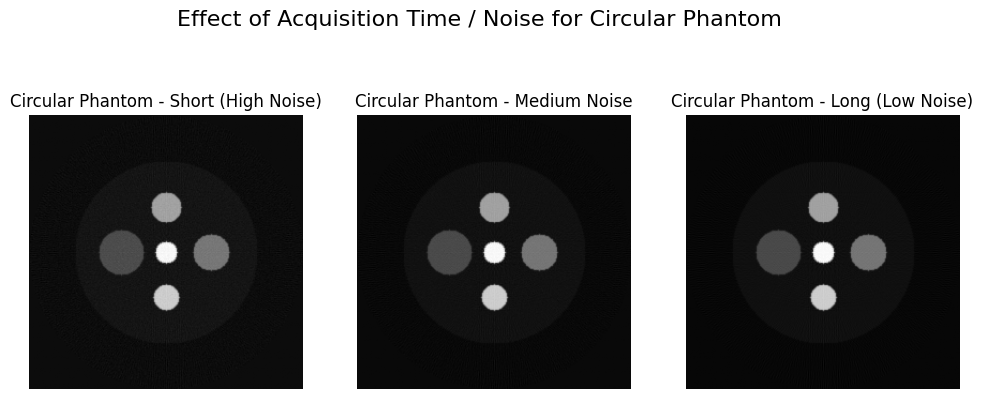

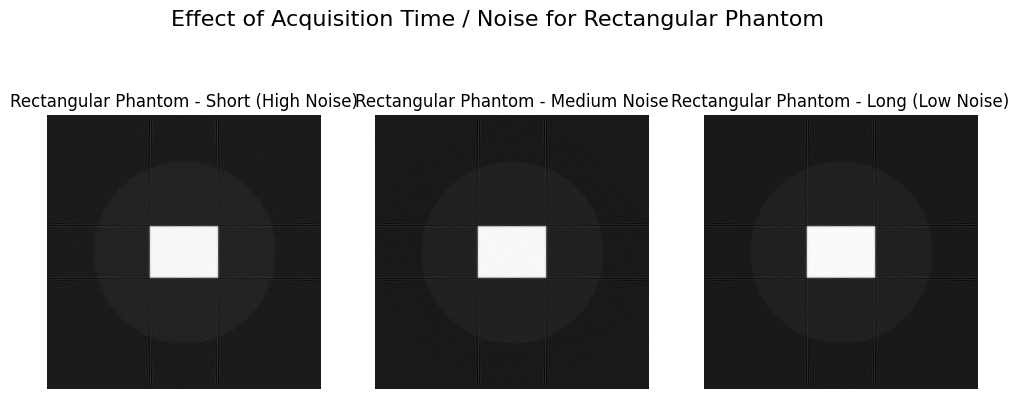

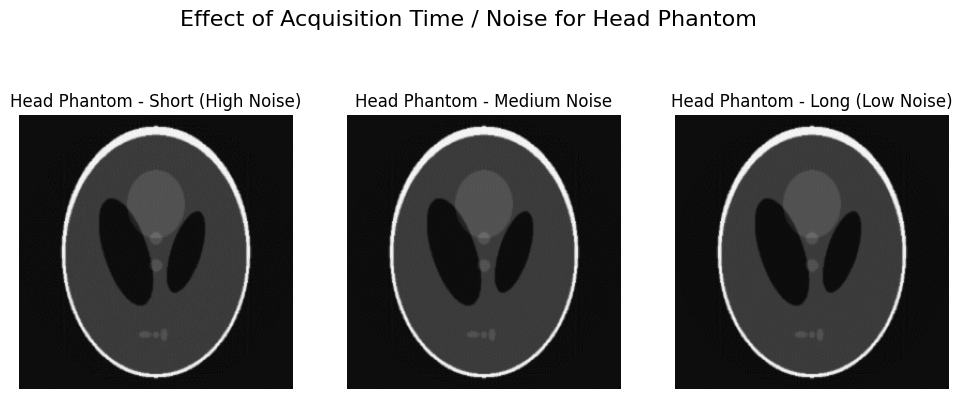

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from skimage.metrics import mean_squared_error, structural_similarity as ssim

# --------------------------
# PREPARE PHANTOMS
# --------------------------
# Create circular and rectangular phantoms as they were not previously defined
phantom_circle = create_circular_phantom(matrix_size=256)
phantom_rectangle = create_rectangular_phantom(matrix_size=256, rect_size=(64, 48), mu_value=0.6)

phantoms = {
    "Circular Phantom": phantom_circle,
    "Rectangular Phantom": phantom_rectangle,
    "Head Phantom": head_phantom # head_phantom is already defined from a previous cell
}

# --------------------------
# ACQUISITION PARAMETER SETS
# --------------------------
projections_list = [36, 90, 180, 360]
detector_counts = [64, 128, 256]
noise_levels = {
    "Short (High Noise)": 0.10,
    "Medium Noise": 0.05,
    "Long (Low Noise)": 0.01
}

# --------------------------
# 1. EFFECT OF NUMBER OF PROJECTIONS
# --------------------------
for phantom_name, phantom in phantoms.items():
    plt.figure(figsize=(12, 10))
    for i, p in enumerate(projections_list):
        theta = np.linspace(0., 180., p, endpoint=False)
        sino = radon(phantom, theta=theta, circle=True)
        recon = iradon(sino, theta=theta, circle=True)

        plt.subplot(2, 2, i+1)
        plt.imshow(recon, cmap='gray')
        plt.title(f"{phantom_name} - {p} Projections")
        plt.axis("off")

    plt.suptitle(f"Effect of Number of Projections for {phantom_name}", fontsize=16)
    plt.show()

# --------------------------
# 2. EFFECT OF NUMBER OF DETECTORS
# --------------------------
for phantom_name, phantom in phantoms.items():
    plt.figure(figsize=(12, 5))
    for i, d in enumerate(detector_counts):
        theta = np.linspace(0., 180., 180, endpoint=False)
        sino = radon(phantom, theta=theta, circle=True)

        # Resample sinogram to new detector size
        sino_resampled = np.zeros((d, sino.shape[1]))
        for col in range(sino.shape[1]):
            sino_resampled[:, col] = np.interp(
                np.linspace(0, sino.shape[0]-1, d),
                np.arange(sino.shape[0]),
                sino[:, col]
            )

        recon = iradon(sino_resampled, theta=theta, circle=True)

        plt.subplot(1, 3, i+1)
        plt.imshow(recon, cmap='gray')
        plt.title(f"{phantom_name} - {d} Detectors")
        plt.axis("off")

    plt.suptitle(f"Effect of Number of Detectors for {phantom_name}", fontsize=16)
    plt.show()

# --------------------------
# 3. EFFECT OF ACQUISITION TIME / NOISE
# --------------------------
for phantom_name, phantom in phantoms.items():
    plt.figure(figsize=(12, 5))
    theta = np.linspace(0., 180., 180, endpoint=False)

    for i, (label, noise) in enumerate(noise_levels.items()):
        sino = radon(phantom, theta=theta, circle=True)

        # Add Gaussian noise
        noisy_sino = sino + noise * np.random.randn(*sino.shape)

        recon = iradon(noisy_sino, theta=theta, circle=True)

        plt.subplot(1, 3, i+1)
        plt.imshow(recon, cmap='gray')
        plt.title(f"{phantom_name} - {label}")
        plt.axis("off")

    plt.suptitle(f"Effect of Acquisition Time / Noise for {phantom_name}", fontsize=16)
    plt.show()